In [3]:
from utils import *

In [4]:
# Setup API
import requests
from requests.compat import urljoin
import json
from time import perf_counter

In [5]:
api_host = "http://localhost"
boxes_endpoint = "boxes/"

boxes_url = urljoin(api_host, boxes_endpoint)
response = requests.get(url=boxes_url)
response.json()[:1]

[{'x_min': 685.0,
  'x_max': 694.0,
  'y_min': 93.0,
  'y_max': 96.0,
  'z_min': 70.0,
  'z_max': 83.0,
  'id': '7b23308c-71b4-4218-bc22-9998a0459342'}]

In [6]:

# for box in boxes:
#     data = {
#         "x_min": min(box[0]),
#         "x_max": max(box[0]),
#         "y_min": min(box[1]),
#         "y_max": max(box[1]),
#         "z_min": min(box[2]),
#         "z_max": max(box[2]),
#     }
#     for key, value in data.items():
#         data[key] = int(value)
#     print(data)
#     response = requests.post(urljoin(api_host, boxes_endpoint), json=data)
#     assert response.status_code == 200, response.json()

In [7]:
def show_3d_boxes(boxes):
    fig = go.Figure()

    for box in boxes:
        add_mesh_3d(fig, box)

    fig.update_layout(
        scene = {
            "xaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
            "yaxis": {
                "nticks": 4, 
                "range": [0, 1000],
            },
            "zaxis": {
                "nticks": 4, 
                "range": [0,1000],
            },
        },
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))

    fig.show()

In [8]:
response = requests.get(f"{boxes_url}?x=20&y=500")

In [10]:
from typing import Dict, Any

def convert_box_json_to_nparray(box_obj: Dict[str, Any]):
    del box_obj["id"]
    box_array = get_box_points_array(
        **box_obj
    )
    return box_array

# convert_box_json_to_nparray(response.json()[0])

In [11]:
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
response_boxes[:2]

[]

Response Time: 0.10149156599800335
Showing 1000 Boxes


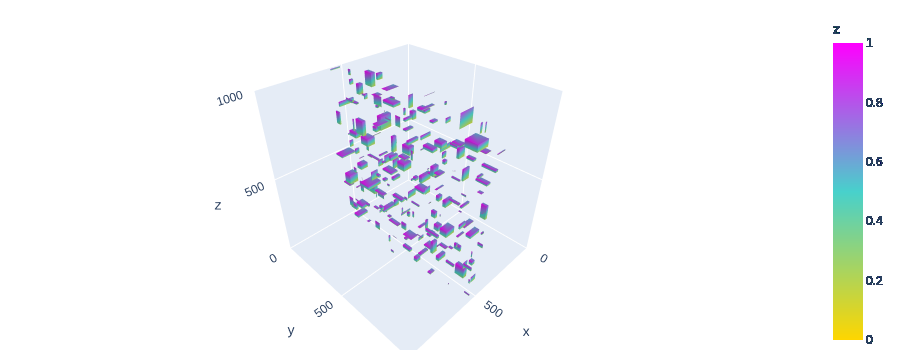

In [25]:
start = perf_counter()
response = requests.get(f"{boxes_url}")
end = perf_counter()
response_boxes = [convert_box_json_to_nparray(box) for box in response.json()]
print(f"Response Time: {end - start}")
print(f"Showing {len(response_boxes)} Boxes")
show_3d_boxes(response_boxes)

In [ ]:
response = requests.get(boxes_url)
response.json()[100:200]